In [1]:
#Paquetes para tratamiento de datos
import pandas as pd
import numpy as np

#Paquetes para gráficos
import matplotlib.pyplot as plt
import seaborn as sns

#Quitar warnings
import warnings
warnings.filterwarnings("ignore")

sns.set_context("paper")
plt.rc("font", size=14)

In [2]:
prices_ask = pd.read_csv(r"C:~Data\USA500IDXUSD_1 Min_Bid_2011.09.19_2023.02.26.csv", sep = ",")
prices_ask["Time (EET)"] = pd.to_datetime(prices_ask["Time (EET)"], format='%Y.%m.%d %H:%M:%S.%f')
prices_ask.set_index("Time (EET)", inplace=True)
prices_ask = prices_ask.between_time('16:30', '23:00')
prices_ask = prices_ask.loc['2013-03-01':]
prices_ask = prices_ask.dropna()

prices_5min_close = prices_ask.groupby([pd.Grouper(level =0, freq='5Min')])["Close"].last()
prices_5min_open = prices_ask.groupby([pd.Grouper(level =0, freq='5Min')])["Open"].first()
prices_5min_high = prices_ask.groupby([pd.Grouper(level =0, freq='5Min')])["High"].max()
prices_5min_low = prices_ask.groupby([pd.Grouper(level =0, freq='5Min')])["Low"].min()

prices = pd.merge(prices_5min_open,prices_5min_close, how='inner', left_index=True, right_index=True)
prices = pd.merge(prices,prices_5min_high, how='inner', left_index=True, right_index=True)
prices = pd.merge(prices,prices_5min_low, how='inner', left_index=True, right_index=True)
prices = prices.dropna()

display(prices.head())
print("Cantidad de datos: ", len(prices))

,Open,Close,High,Low
Time (EET),,,,
2013-03-01 16:30:00,1513.131,1513.301,1513.355,1513.102
2013-03-01 16:35:00,1513.336,1513.103,1513.337,1513.098
2013-03-01 16:40:00,1513.226,1513.152,1513.348,1513.103
2013-03-01 16:45:00,1513.249,1513.267,1513.337,1513.142
2013-03-01 16:50:00,1513.124,1503.929,1513.359,1503.599


Cantidad de datos:  202653


In [3]:
#Calcular los retornos
#returns = (prices['Close'] - prices['Open'])/prices['Open']
returns = np.log(prices['Close']/prices['Close'].shift()).dropna()
returns = returns[returns != 0]
display(returns.head())
print("Cantidad de días: ", len(returns))

Time (EET)
2013-03-01 16:35:00   -0.000131
2013-03-01 16:40:00    0.000032
2013-03-01 16:45:00    0.000076
2013-03-01 16:50:00   -0.006190
2013-03-01 16:55:00    0.000730
Name: Close, dtype: float64

Cantidad de días:  192993


In [4]:
returns_sq = pd.DataFrame(returns**2)
returns_sq['date'] = returns_sq.index

real_vol = np.log(np.sqrt(returns_sq.groupby([pd.Grouper(key='date', freq='d')])["Close"].sum()))

real_vol = real_vol[real_vol > -50] #Quitar valores -inf

display(real_vol.head())
print("Cantidad de datos: ", len(real_vol))

date
2013-03-01   -4.688677
2013-03-04   -5.206986
2013-03-05   -4.946116
2013-03-06   -5.350190
2013-03-07   -5.677612
Name: Close, dtype: float64

Cantidad de datos:  2582


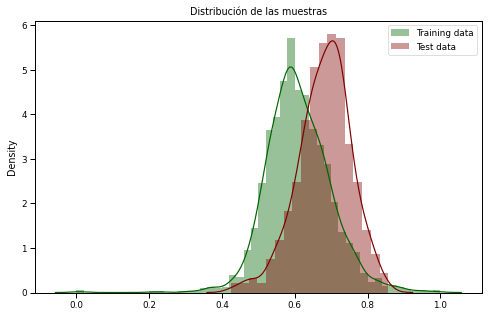

In [5]:
from sklearn.preprocessing import MinMaxScaler

n = len(real_vol)

data = np.array(real_vol).reshape(-1,1)

train = data[0:int(n*0.7)]
val = data[int(n*0.7):int(n*0.85)]
train_val = data[0:int(n*0.85)]
test = data[int(n*0.85):] #Reservar muestra desconocida

scaler = MinMaxScaler()
scaler.fit(train_val)

mean = np.mean(train)
cuasi_std = np.std(train, ddof = 1)


train = scaler.transform(train)
val = scaler.transform(val)
train_val = scaler.transform(train_val)
data = scaler.transform(data)
test = scaler.transform(test)

#train = (train - mean)/cuasi_std
#val = (val - mean)/cuasi_std
#test = (test - mean)/cuasi_std

sns.set_context("paper")
fig, ax = plt.subplots(figsize = (8,5))
sns.distplot(train_val, kde=True, color = "darkgreen", label = "Training data")
sns.distplot(test, kde=True, label = "Test data", color = "maroon",)

plt.title("Distribución de las muestras")
plt.legend()
plt.show()

In [6]:
from statsmodels.tsa.stattools import adfuller

#Check Stationarity
res_diff =  adfuller(data)
print(f'ADF Test p-value: {res_diff[1]}')
#If p-value below 0.05 means, that the returns are stationary 

#NO ES SAISONAL

ADF Test p-value: 2.0149295087303055e-07


# MODELO LINEAL: ARMA

In [7]:
from statsmodels.tsa.arima.model import ARIMA

In [22]:
from statsmodels.tsa.arima.model import ARIMA

print("AIC: ARMA Models")
ar = range(0,6,1)
i_val = [0,1]
ma = range(0,6,1)

config_ar = []
config_i = []
config_ma = []
aic_res = []

for x in ar : 
        for z in ma : 
            arima_tune = ARIMA(train_val, order=(x, 0, z)).fit()

            config_ar.append(x)
            config_ma.append(z)
            aic_res.append(arima_tune.aic)

zmin = np.min(aic_res)
mask = np.array(aic_res) == zmin
color = np.where(mask, 'maroon', '#002366')

AIC: ARMA Models


C:\Users\super\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\super\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\super\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\super\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\super\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

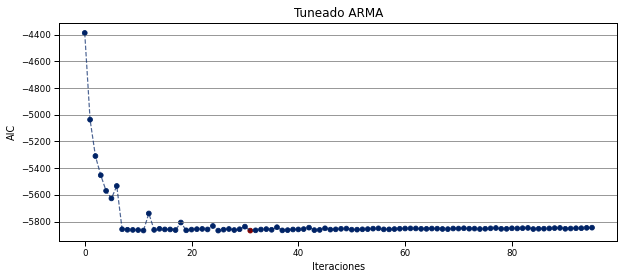

La configuración óptima es:  AR [5] MA [1]


In [21]:
sns.set_context("paper")
fig, ax = plt.subplots(figsize = (10,4))
plt.scatter(x = range(0,len(aic_res)), y = aic_res, color=color, alpha = 1)
plt.plot(range(0,len(aic_res)), aic_res, alpha = 0.7, color = '#002366', linestyle = "--")
plt.ticklabel_format(useOffset=False) 

plt.title("Tuneado ARMA", fontsize = 12)
plt.ylabel("AIC")
plt.xlabel("Iteraciones")
plt.grid(axis = "y", color = "0.5")
plt.show()
print("La configuración óptima es: ", 'AR' , np.array(config_ar)[np.array(aic_res) == zmin], 
      'MA',
      np.array(config_ma)[np.array(aic_res) == zmin])

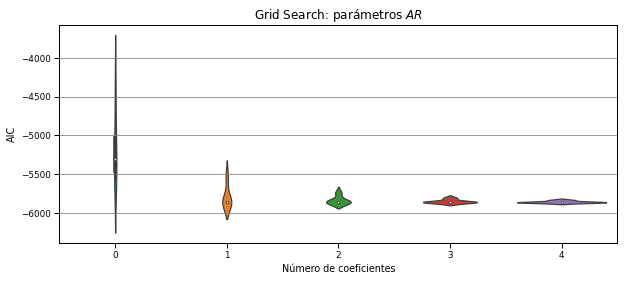

In [12]:
sns.set_context("paper")
fig, ax = plt.subplots(figsize = (10,4))
sns.violinplot(x=config_ar, y=aic_res)
#plt.ticklabel_format(useOffset=False) 

plt.title(r"Grid Search: parámetros $AR$", fontsize = 12)
plt.ylabel("AIC")
plt.xlabel("Número de coeficientes")
plt.grid(axis = "y", color = "0.5")
plt.show()

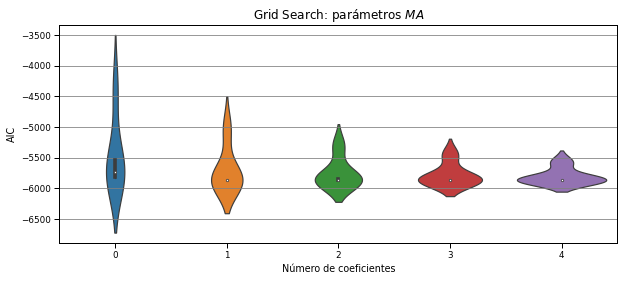

In [136]:
sns.set_context("paper")
fig, ax = plt.subplots(figsize = (10,4))
sns.violinplot(x=config_ma , y=aic_res)
#plt.ticklabel_format(useOffset=False) 

plt.title(r"Grid Search: parámetros $MA$", fontsize = 12)
plt.ylabel("AIC")
plt.xlabel("Número de coeficientes")
plt.grid(axis = "y", color = "0.5")
plt.show()

In [8]:
#Con ARMA 4,1 hay problemas de convergencia (seguramente por multicolinearidad), en este caso se utilizará 3,1

arma_model = ARIMA(train_val, order=(5, 0, 1)).fit()

print(arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2194
Model:                 ARIMA(5, 0, 1)   Log Likelihood                2941.937
Date:                Fri, 19 May 2023   AIC                          -5867.874
Time:                        00:21:32   BIC                          -5822.327
Sample:                             0   HQIC                         -5851.229
                               - 2194                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6094      0.013     47.146      0.000       0.584       0.635
ar.L1          1.2352      0.041     30.005      0.000       1.155       1.316
ar.L2         -0.1344      0.028     -4.726      0.0

C:\Users\super\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


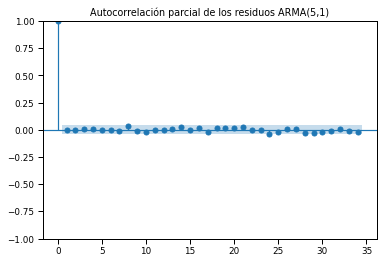

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#With PACF see possible spikes: AR 
sns.set_context("paper")
plot_pacf(arma_model.resid)
plt.title("Autocorrelación parcial de los residuos ARMA(5,1)")
plt.show()

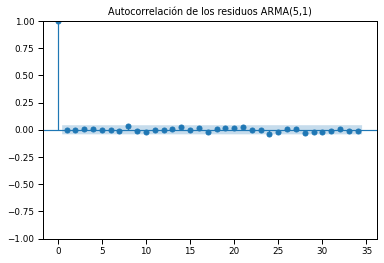

In [12]:
sns.set_context("paper")
#With ACF see possible spikes: MA
plot_acf(arma_model.resid)
plt.title("Autocorrelación de los residuos ARMA(5,1)")
plt.show()

In [11]:
import warnings
warnings.filterwarnings("ignore")

predictions = []
for i in range(0,len(test)):
    arma_temp = ARIMA(data[0:(int(n*0.85)+i)], order=(5, 0, 1)).fit()
    
    pred_1_step = arma_temp.forecast()
    value = pred_1_step[0]
    
    predictions.append(value)

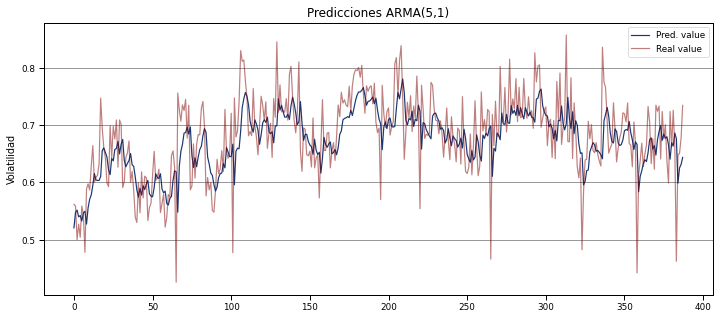

In [12]:
sns.set_context("paper")
fig, ax = plt.subplots(figsize = (12,5))


#plt.scatter(x = range(0,len(predictions)), y = predictions, color='#002366', alpha = 1)
plt.plot(range(0,len(predictions)), predictions, alpha = 0.9, color = '#002366', label = "Pred. value")

#plt.scatter(x = range(0,len(predictions)), y = test, color='maroon', alpha = 1)
plt.plot(range(0,len(predictions)), test, alpha = 0.5, color = 'maroon', label = "Real value")

plt.legend()
plt.ticklabel_format(useOffset=False) 
plt.title("Predicciones ARMA(5,1)", fontsize = 12)
plt.ylabel("Volatilidad")
#plt.xlabel("Iteraciones")
plt.grid(axis = "y", color = "0.5")
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test, predictions)
print('Test MSE: %.6f' % mse)

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test, predictions)
print('Test MAE: %.6f' % mae)

from sklearn.metrics import r2_score

print("El pseudo R2 obtenido es: "+ str(round(r2_score(test, predictions),5)))

Test MSE: 0.003351
Test MAE: 0.042644
El pseudo R2 obtenido es: 0.36801


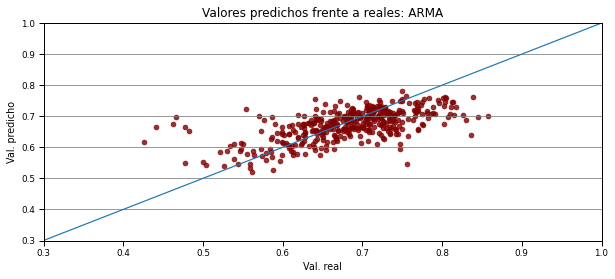

In [14]:
sns.set_context("paper")
fig, ax = plt.subplots(figsize = (10,4))

plt.scatter(test,predictions, c= "maroon", alpha=0.8)

plt.axline([0, 0], slope=1)
plt.xlim(0.3, 1) 
plt.ylim(0.3, 1) 
plt.title("Valores predichos frente a reales: ARMA", fontsize = 12)
plt.xlabel("Val. real")
plt.ylabel("Val. predicho")
plt.grid(axis = "y", color = "0.5")
plt.show()

# MODELO NAR: Polinomial

## por ejecutar

In [15]:
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.display_results import results

ylags = 10

basis_function = Polynomial(degree=3)
model_nar = FROLS(
    order_selection=True,
    ylag=ylags, # the lags for all models will be 13
    basis_function=basis_function,
    info_criteria='aic',
    estimator='least_squares',
    model_type='NAR')

In [16]:
model_nar.fit(y = train_val)
r = pd.DataFrame(
    results(
        model_nar.final_model, model_nar.theta, model_nar.err,
        model_nar.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
print(r)

           Regressors   Parameters             ERR
0              y(k-1)  -5.0608E-01  9.85039829E-01
1              y(k-2)  -3.5501E-01  2.69298385E-03
2                   1   5.2764E-01  1.06412894E-03
3  y(k-8)y(k-4)y(k-3)   8.2256E-01  6.61794689E-04
4            y(k-1)^2   1.2711E+00  2.44228853E-04
5            y(k-1)^3  -3.0247E-01  5.22479693E-05
6            y(k-2)^2   7.8932E-01  4.54294718E-05
7  y(k-8)y(k-4)y(k-1)  -8.0534E-01  2.29926203E-05
8      y(k-3)y(k-2)^2  -5.5939E-01  7.73363716E-05
9  y(k-8)y(k-6)y(k-4)   1.1300E-01  2.18704669E-05


In [17]:
pred_nar = []
y_test = np.concatenate([train[-model_nar.max_lag:], test])
for i in range(0,len(test)):
    y_temp = y_test[i:(ylags+i)]
    
    pred_1_step = model_nar.predict(y = y_temp, forecast_horizon = 1)
    value = pred_1_step[ylags]
    
    pred_nar.append(value)
pred_nar = np.array(pred_nar)

In [23]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test, pred_nar)
print('Test MSE: %.6f' % mse)

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test, pred_nar)
print('Test MAE: %.6f' % mae)

from sklearn.metrics import r2_score

print("El pseudo R2 obtenido es: "+ str(round(r2_score(test, pred_nar),5)))

Test MSE: 0.003539
Test MAE: 0.043588
El pseudo R2 obtenido es: 0.33252


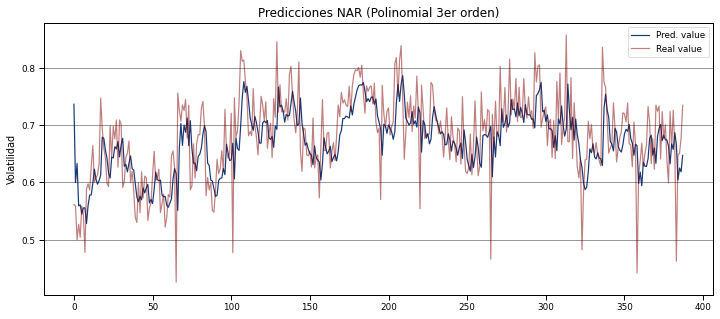

In [19]:
sns.set_context("paper")
fig, ax = plt.subplots(figsize = (12,5))


#plt.scatter(x = range(0,len(predictions)), y = predictions, color='#002366', alpha = 1)
plt.plot(range(0,len(pred_nar)), pred_nar, alpha = 0.9, color = '#002366', label = "Pred. value")

#plt.scatter(x = range(0,len(predictions)), y = test, color='maroon', alpha = 1)
plt.plot(range(0,len(pred_nar)), test, alpha = 0.5, color = 'maroon', label = "Real value")

plt.legend()
plt.ticklabel_format(useOffset=False) 
plt.title("Predicciones NAR (Polinomial 3er orden)", fontsize = 12)
plt.ylabel("Volatilidad")
#plt.xlabel("Iteraciones")
plt.grid(axis = "y", color = "0.5")
plt.show()

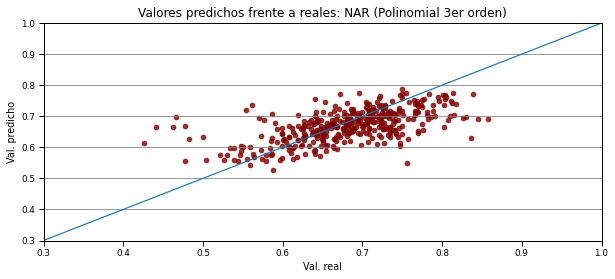

In [20]:
sns.set_context("paper")
fig, ax = plt.subplots(figsize = (10,4))

plt.scatter(test,pred_nar, c= "maroon", alpha=0.8)

plt.axline([0, 0], slope=1)
plt.xlim(0.3, 1) 
plt.ylim(0.3, 1) 
plt.title("Valores predichos frente a reales: NAR (Polinomial 3er orden)", fontsize = 12)
plt.xlabel("Val. real")
plt.ylabel("Val. predicho")
plt.grid(axis = "y", color = "0.5")
plt.show()